In [1]:
from lib.helpers import np_exclude
from lib import algos, helpers, envs
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
from joblib import Parallel, delayed
import pickle

In [2]:
np.random.seed(42)
env = envs.FrozenLakeEnv_slip_rand_reward(
    map_name="4x4", 
    slip_prob=0.0,
    reward_modifier = [0.01, 0.02, 0.03, 0.04],
)

In [3]:
gamma_range = np.linspace(0, 1.0, 51)[:-1]
zeta_range = np.linspace(0, 1.0, 51)
param_grid = list(itertools.product(gamma_range, zeta_range))

In [4]:
Qs_by_param = {}
iterations = {}
converged = {}
deltas = {}
for gamma, zeta in tqdm(param_grid):
    V_STAR = algos.value_iter(env, gamma)
    Q_STAR = algos.V2Q(env, V_STAR, gamma)
    V, metadata = algos.value_iter_near_greedy(env, gamma, zeta=zeta, V_star=V_STAR, max_iter=1000)
    Q = algos.V2Q(env, V, gamma)
    policies, delta = metadata['policies'], metadata['delta']
    Qs_by_param[gamma, zeta] = Q_STAR, Q, zeta
    iterations[gamma, zeta] = len(policies) - 1
    converged[gamma, zeta] = (policies[-1] == policies[-2]).all() #(delta < 1e-10)
    deltas[gamma, zeta] = delta

100%|██████████| 2550/2550 [27:48<00:00,  1.53it/s]


In [5]:
# TDE at end of learning
policy_tdes = deltas
df_tde = pd.DataFrame()
df_tde.index.name = 'zeta'
df_tde.columns.name = 'gamma'
for zeta in zeta_range:
    for gamma in gamma_range:
        df_tde.loc[zeta,gamma] = policy_tdes[gamma,zeta]
    df_tde.loc[zeta, 1.0] = np.nan

# Average policy size
policy_sizes = {}
for gamma, zeta in param_grid:
    Q_star, Q, zeta_ = Qs_by_param[gamma, zeta]
    assert zeta == zeta_
    V_star = Q_star.max(axis=1, keepdims=True)
    pi = (np_exclude(Q, env.S_terminal) >= (1-zeta) * np_exclude(V_star, env.S_terminal)).astype(int)
    policy_size = pi.sum(axis=1).mean()
    policy_sizes[gamma, zeta] = policy_size

df_policy_sizes = pd.Series(policy_sizes).unstack().T
df_policy_sizes.index.name = 'zeta'
df_policy_sizes.columns.name = 'gamma'
df_policy_sizes.loc[:, 1.0] = np.nan

# Converged?
df_converged = pd.Series(converged).unstack().T

In [ ]:
df_tde.to_csv('output_converge/lake4x4_tde.csv')
df_policy_sizes.to_csv('output_converge/lake4x4_psize.csv')
df_converged.to_csv('output_converge/lake4x4_converged.csv')
joblib.dump({'policy_sizes': policy_sizes, 'policy_tdes': policy_tdes, 'converged': converged}, 'output_converge/lake4x4.joblib')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [12]:
import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif'

In [10]:
df_policy_sizes = pd.read_csv('output_converge/lake4x4_psize.csv', index_col='zeta')
f = joblib.load('output_converge/lake4x4.joblib')
policy_sizes = f['policy_sizes']
policy_tdes = f['policy_tdes']
converged = f['converged']

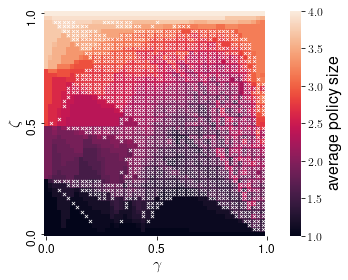

In [14]:
coords_policy = []
coords_i = []
for i, (gamma, zeta) in enumerate(param_grid):
    try:
        psize = policy_sizes[gamma, zeta]
        ptde = policy_tdes[gamma, zeta]
        pconv = converged[gamma, zeta]
    except:
        psize = policy_sizes[np.around(gamma,2), np.round(zeta,2)]
        ptde = policy_tdes[np.around(gamma,2), np.round(zeta,2)]
        pconv = converged[np.around(gamma,2), np.round(zeta,2)]
    
    if not pconv:
        coords_policy.append((gamma, zeta))
        coords_i.append((i//51+0.5, i%51+0.5))

# fig, ax = plt.subplots(figsize=(4,4))
ax = sns.heatmap(
    df_policy_sizes, square=True, #ax=ax,
    cbar_kws=dict(label='average policy size'),
#     vmin=1, vmax=2000,
    xticklabels=25, yticklabels=25,
)
ax.invert_yaxis()
ax.tick_params(labelsize='large')
cbar = ax.collections[0].colorbar.ax.tick_params(labelsize=12)
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.xlabel('$\gamma$', fontsize=16)
plt.ylabel('$\zeta$', fontsize=16)
plt.scatter(*zip(*coords_i), c='w', s=10, marker='x', linewidth=.75)
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.tight_layout()
plt.savefig('figures/converge_lake4x4.pdf', bbox_inches='tight')
plt.show()